In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [6]:
p_ft = 300 * 100
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
# ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
# ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
#                                        np.atleast_1d(p_ft)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

I consider two empirical methods:
1. Potential temperature deviation from surface exceeds threshold.
2. This plus additional requirement that lapse rate in the model layer is below a threshold.

In [7]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))
ds['z_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)
ds['T_at_lcl'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl)
ds['Z_at_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)

In [8]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_pot_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)
    temp_pot_start = potential_temp(temp_start, p_start)
    mask = (temp_pot_env - temp_pot_start) > temp_pot_thresh
    # Find highest level where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(temp_env.lev.size)).max(dim='lev') + 1).astype(int)

    # Find level in between model levels where diff of pot temp from the surface is exactly temp_thresh
    # Assume fixed lapse rate in log pressure coords between adjacent model levels
    p_low = np.log10(p_env.isel(lev=lcl_ind))  # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind - 1))  # further from surface

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind - 1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_start + temp_pot_thresh
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_lcl = 10 ** p_target
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)


def find_lcl_empirical2(temp_env, p_env, z_env, temp_start=None, p_start=None, temp_pot_thresh=2,
                        temp_pot_thresh_lapse=0.5, lapse_thresh=8.5):
    # Find the lowest model layer with lapse rate less than lapse_thresh
    # LCL is the level at which the pot temp drops by 0.5K within this layer
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    temp_pot_env = potential_temp(temp_env, p_env)

    # First mask is pot temp close to surface pot temperature
    temp_pot_start = potential_temp(temp_start, p_start)
    mask_temp = np.abs(temp_pot_env - temp_pot_start) <= temp_pot_thresh

    # Second mask is lapse rate close to dry adiabat
    # lower is so append high value at surface
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)  # make same shape
    lapse = lapse.fillna(lapse_thresh + 5)  # ensure final value satisfies lapse criteria
    mask_lapse = lapse > lapse_thresh
    mask = (mask_temp & mask_lapse)
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).min(dim='lev')).astype(int)

    p_low = np.log10(p_env.isel(lev=lcl_ind))  # use log as better for interpolation - gradient is approx constant
    p_high = np.log10(p_env.isel(lev=lcl_ind - 1))  # further from surface

    # print(p_low)
    # print(p_high)
    # print(np.log10(p_env))

    temp_pot_low = temp_pot_env.isel(lev=lcl_ind)
    temp_pot_high = temp_pot_env.isel(lev=lcl_ind - 1)
    gradient = (temp_pot_high - temp_pot_low) / (p_high - p_low)
    temp_pot_target = temp_pot_low + temp_pot_thresh_lapse
    p_target = p_low + (temp_pot_target - temp_pot_low) / gradient
    p_target = p_target.clip(min=p_high)
    p_lcl = 10 ** p_target
    # print(dry_profile_temp(temp_start, p_start, p_lcl))
    # print(lapse.isel(lev=lcl_ind-1))
    return p_lcl, dry_profile_temp(temp_start, p_start, p_lcl)


def get_lnb_lev_ind(temp_env, z_env, p_env, p_max=400 * 100, lapse_thresh=5, lapse_change_thresh=2, n_iter=5):
    """
    LNB must be a pressure lower than p_max.
    LNB is level above which is the first layer with negative lapse rate.
    If lapse rate in level immediately below this deviates from the lapse rate in the level below that or two below that,
    then LNB is moved to a lower level by 1. This process is repeated n_iter times.
    Also require lapse rate in level immediately below LNB to be less than lapse_thresh.
    """
    lapse = -temp_env.diff(dim='lev', label='lower') / z_env.diff(dim='lev', label='lower') * 1000
    lapse = lapse.reindex_like(temp_env)  # make same shape
    lapse = lapse.fillna(lapse_dry * 1000)  # ensure final value satisfies lapse criteria
    lapse = lapse.where(p_env < p_max)
    mask = lapse < 0
    lnb_ind = (mask.where(mask, other=np.nan) * np.arange(lapse.lev.size)).max(dim='lev').astype(int)
    # lnb_ind = np.where(lapse < 0)[0][-1]
    # If lapse rate has very big variation, push LNB closer to surface
    for j in range(n_iter):
        is_large_lapse_diff = lapse.isel(lev=lnb_ind + 2) - lapse.isel(lev=lnb_ind + 1) > lapse_change_thresh
        is_large_lapse_diff = is_large_lapse_diff & (lapse.isel(lev=lnb_ind + 1) < lapse_thresh)
        is_large_lapse_diff2 = lapse.isel(lev=lnb_ind + 3) - lapse.isel(lev=lnb_ind + 1) > lapse_change_thresh
        is_large_lapse_diff2 = is_large_lapse_diff2 & (lapse.isel(lev=lnb_ind + 1) < lapse_thresh)
        is_large_lapse_diff = is_large_lapse_diff | is_large_lapse_diff2
        lnb_ind = lnb_ind + is_large_lapse_diff.astype(int)
    lnb_ind = lnb_ind + 1  # make it up to and including this level
    return lnb_ind


ds['p_lcl_emp'], ds['T_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)
ds['p_lcl_emp2'], ds['T_lcl_emp2'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3)
ds['T_at_lcl_emp'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl_emp)
ds['T_at_lcl_emp2'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl_emp2)
ds['Z_at_lcl_emp2'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl_emp2)
ds['lnb_ind'] = get_lnb_lev_ind(ds.T, ds.Z3, ds.P)

In [9]:
ds['mse_sat'] = moist_static_energy(ds.T, sphum_sat(ds.T, ds.P), ds.Z3)
ds['mse_sat_at_lcl'] = moist_static_energy(ds['T_at_lcl'], sphum_sat(ds['T_at_lcl'], ds['p_lcl']), ds['Z_at_lcl'])
ds['mse_sat_at_lcl_emp2'] = moist_static_energy(ds['T_at_lcl_emp2'], sphum_sat(ds['T_at_lcl_emp2'], ds['p_lcl_emp2']), ds['Z_at_lcl_emp2'])

In [10]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

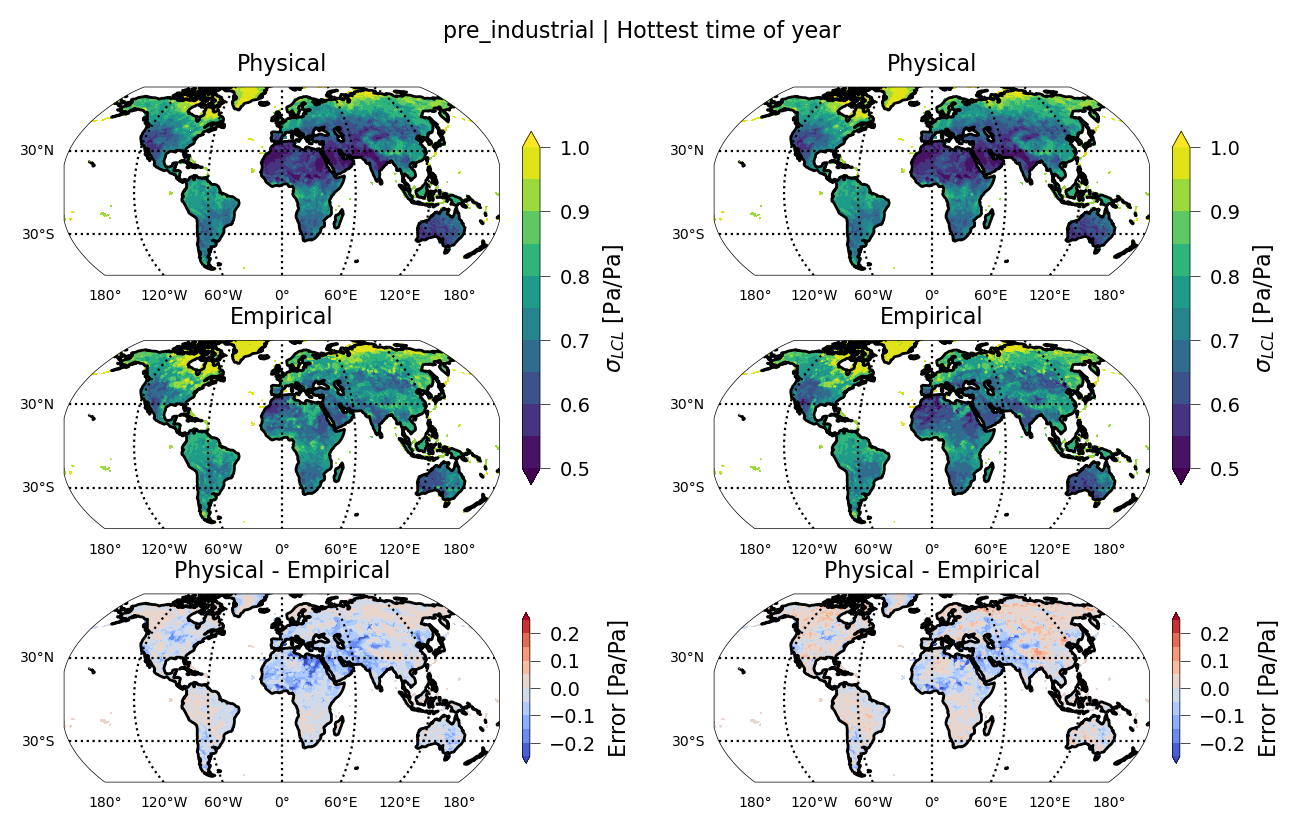

In [11]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(6.5, 4))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
for ax_use in ax.flatten():
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
# initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 0], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 0], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 0], label='Error [Pa/Pa]', mappable=im)

plot_contour_projection(ax[0, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1, 1], (ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2, 1], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2, 1], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp2'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))
fig.colorbar(shrink=0.8, ax=ax[2, 1], label='Error [Pa/Pa]', mappable=im)

fig.suptitle(f'{exp_name[co2_ind]} | Hottest time of year', fontsize=8)
for i in range(2):
    ax[0, i].set_title('Physical')
    ax[1, i].set_title('Empirical')
    ax[2, i].set_title('Physical - Empirical')
# isca_tools.savefig(fig)
plt.show()

### Individual Locations
Below, I look at the LCL applied to a specific location, to visualize the difference to the physical LCL.

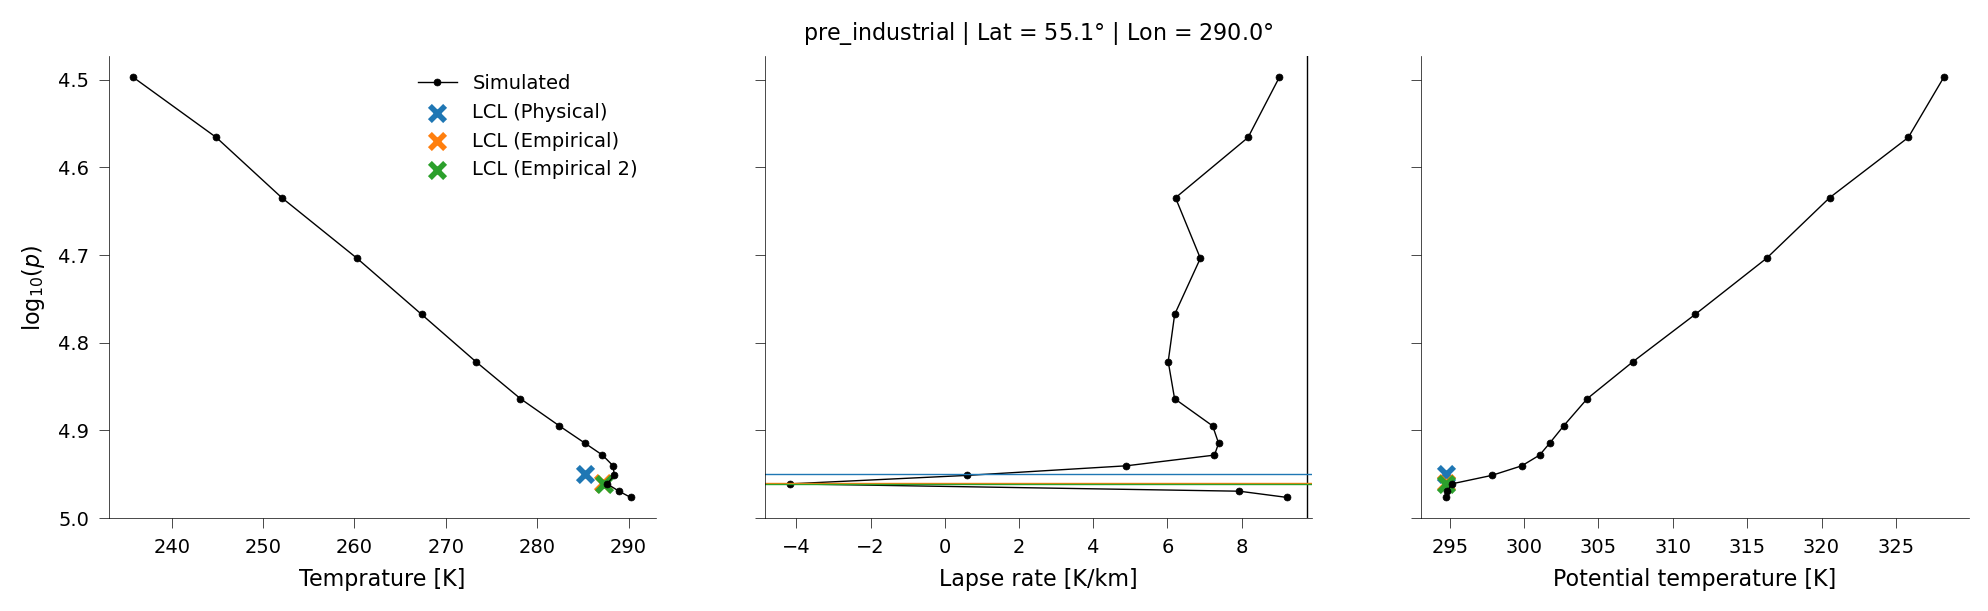

In [12]:
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320,method='nearest')      # Amazon 1
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300,method='nearest')    # Amazon 2
# ds_use = ds.isel(co2=1).sel(lat=3, lon=15, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=3, lon=20, method='nearest')        # Congo
# ds_use = ds.isel(co2=1).sel(lat=50, lon=25, method='nearest')        # Europe
ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Canada
# ds_use = ds.isel(co2=1).sel(lat=35, lon=100, method='nearest')        # Tibet
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')      # Pursian Gulf
# ds_use = ds.isel(co2=0).sel(lat=28, lon=50, method='nearest')       # Pursian Gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=35, lon=260, method='nearest')
ds_use['lapse_rate'] = -ds_use.T.diff(dim='lev', label='upper') / ds_use.Z3.diff(dim='lev', label='upper') * 1000

show_lnb = False
if show_lnb:
    p_max = 30 * 100
else:
    p_max = 300 * 100

fig, ax = plt.subplots(1, 3, sharey=True)
fig_resize(fig, 12)
ax[0].plot(ds_use.T.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

x_var = ds_use['lapse_rate'].where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
y_var = np.log10(ds_use.P).isel(lev=slice(1, 999999)).where(ds_use.P.isel(lev=slice(1, 999999)) > p_max)
ax[1].plot(x_var, y_var, marker='o', color='k')
ax[1].axvline(lapse_dry * 1000, color='k')

ds_use['T_pot'] = potential_temp(ds_use.T, ds_use.P)
ax[2].plot(ds_use.T_pot.where(ds_use.P > p_max), np.log10(ds_use.P).where(ds_use.P > p_max), marker='o', color='k',
           label='Simulated')

# Add LCL info
var = find_lcl_empirical2(ds_use.T, ds_use.P, ds_use.Z3)
var = find_lcl_empirical(ds_use.T, ds_use.P)
ax[0].scatter(ds_use.T_lcl, np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', label='LCL (Physical)')
ax[0].scatter(ds_use.T_lcl_emp, np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', label='LCL (Empirical)')
ax[0].scatter(ds_use.T_lcl_emp2, np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2',
              label='LCL (Empirical 2)')
ax[1].axhline(np.log10(ds_use.p_lcl), color='C0')
ax[1].axhline(np.log10(ds_use.p_lcl_emp), color='C1')
ax[1].axhline(np.log10(ds_use.p_lcl_emp2), color='C2')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2,
              color='C1')
ax[2].scatter(potential_temp(ds_use.TREFHT, ds_use.PREFHT), np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2,
              color='C2')

if show_lnb:
    ax[0].scatter(ds_use.T.isel(lev=ds_use.lnb_ind), np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)), marker='_', s=400,
                  lw=1, color='C0')

ax[0].invert_yaxis()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temprature [K]')
ax[1].set_xlabel('Lapse rate [K/km]')
ax[2].set_xlabel('Potential temperature [K]')
ax[0].legend()
ax[1].set_title(f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$")
plt.show()

### Size of layer above LCL and below FT level
Next, we want to consider the temperature profile above the LCL but below the LNB level. The minimum size of this layer is approx $p_{LCL}/p_{LNB} = 10^{0.45} = 2.82$, as shown below.

So for an LCL at sea level pressure of 1000hPa, the LNB would be about 350hPa, as shown below.

354.81338923357526


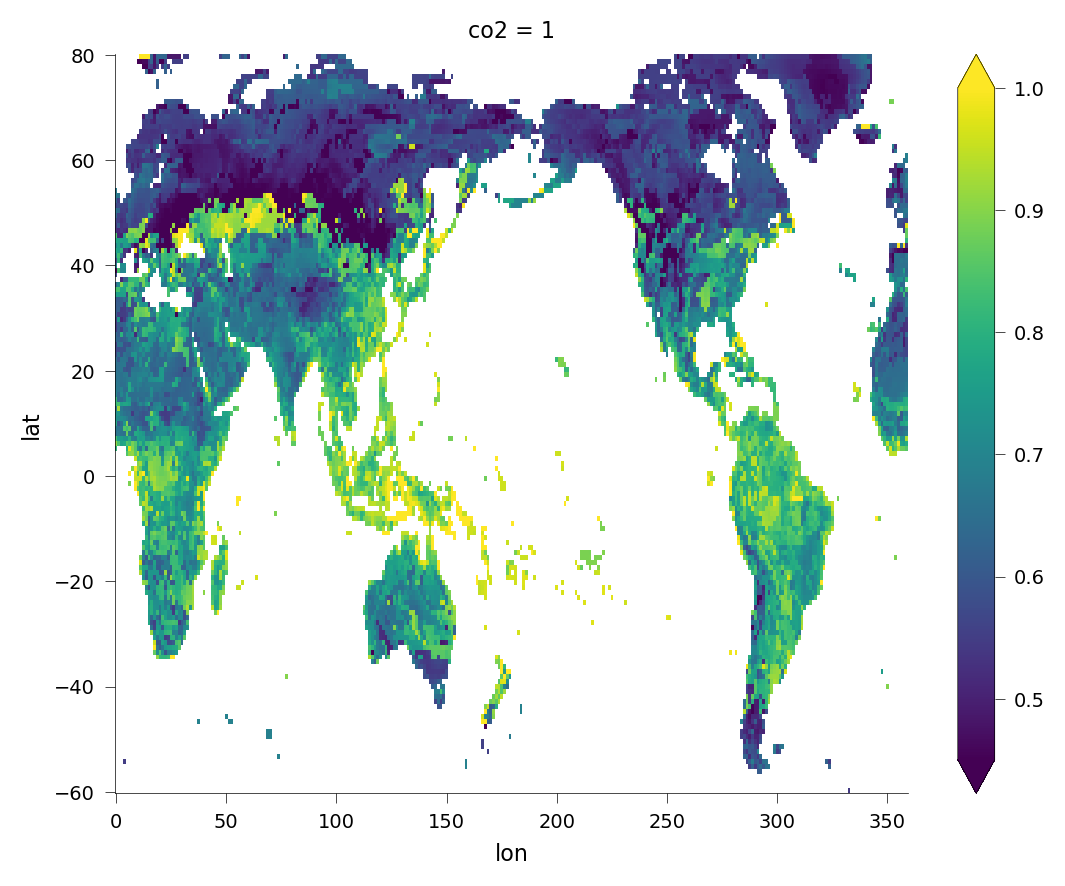

In [13]:
# lcl_use = '_lcl_emp2'
lcl_use = '_lcl'
(np.log10(ds[f'p{lcl_use}']) - np.log10(ds.P.isel(lev=ds.lnb_ind))).isel(co2=0).where(lsm).sel(lat=slice(-60, 80)).plot(
    vmin=0.45, vmax=1)
print(10 ** (np.log10(1000 * 100) - 0.45) / 100)

### Interpolation in region between LCL and LNB
The temperature profiles show pretty uniform lapse rates when plotted against $\log_{10}(p)$, so we want a grid uniform in this space.

I.e. we want to go from $\log_{10}(p_{LCL}) - \log_{10}(p) = 0$ to $0.45$ in equal steps e.g. 0.05.

In the example, we show in blue the profile used above between LCL and LNB for this region. The pressure levels marked as above LNB are not used to characterize the profile because they are in a different (stratospheric) regime.

In [14]:
def interp_nan(x, y):
    # Set all nan values in x based on the two nearest indices that are not nan
    # using linear interpolation
    not_valid = np.isnan(y)
    if not_valid.sum() == 0:
        return y, np.zeros(0)
    else:
        valid_idx = np.where(~not_valid)[0]
        not_valid_idx = np.where(not_valid)[0]
        for i in not_valid_idx:
            if i < valid_idx[0]:
                # Case: before first valid point
                j1, j2 = valid_idx[0], valid_idx[1]
            elif i > valid_idx[-1]:
                # Case: after last valid point
                j1, j2 = valid_idx[-2], valid_idx[-1]
            else:
                # Case: between valid points
                # nearest valid indices around i
                j2 = valid_idx[valid_idx > i][0]
                j1 = valid_idx[valid_idx < i][-1]
            # Linear interpolation between (x[j1], y[j1]) and (x[j2], y[j2])
            slope = (y[j2] - y[j1]) / (x[j2] - x[j1])
            y[i] = y[j1] + slope * (x[i] - x[j1])
    return y, not_valid_idx

def interp_var_to_logp(var: xr.DataArray,
                       p: xr.DataArray,
                       var_at_lcl: xr.DataArray,
                       p_lcl: xr.DataArray,
                       lnb_ind: xr.DataArray,
                       d_logp: float = 0.025,
                       logp_max: float = 0.45,
                       logp_custom_grid: Optional[np.ndarray] = None,
                       extrapolate=True) -> Tuple[xr.DataArray, xr.DataArray]:
    """Interpolate variable profiles relative to LCL into log pressure-space.

    Each grid cell has its own model levels and LCL pressure.
    The function interpolates var(logp) - var_LCL onto a uniform logp grid
    from 0 to lop_max above the LCL, in steps of d_logp.

    Args:
        var (xr.DataArray): Variable to interpolate, dims ('lat', 'lon', 'lev').
        p (xr.DataArray): Pressure [Pa] corresponding to `var`, dims ('lat', 'lon', 'lev').
        p_lcl (xr.DataArray): LCL pressure [hPa], dims ('lat', 'lon').
        lnb_ind (xr.DataArray): Index above which is influenced by stratosphere
        d_logp (float): Vertical spacing for interpolation grid of logp.
        logp_max (float): Height above LCL to interpolate up to.
        extrapolate: If True, will set values above LNB using linear extrapolation from the 2 nearest points.
            Otherwise, will set to nan

    Returns:
        xr.DataArray: Interpolated T - T_LCL,
            dims ('lat', 'lon', 'logp_rel') where z_rel is height above LCL [m].
        xr.DataArray: Number of `logp_rel` values found by extrapolation.
            Only non-zero if `extrapolate` is True.
    """
    small = 1
    var = var.where(p >= p.isel(lev=lnb_ind) - small)       # set var to nan above LNB
    # p = p.where(p >= p.isel(lev=lnb_ind) - small)         # Must have p always be actual values, not allowed NaN with np.interp
    # Define target relative z-grid
    if logp_custom_grid is None:
        logp_rel = np.arange(0, logp_max + d_logp, d_logp)
    else:
        logp_rel = logp_custom_grid

    def _interp_onecell(var_prof, p_prof, var_at_lcl, p_lcl):
        # Skip missing
        # print(p_prof)
        # print(p_lcl)
        if np.all(np.isnan(var_prof)):
            return np.full_like(logp_rel, np.nan, dtype=float)

        # Shift to relative z grid
        logp_target = np.log10(p_lcl) - logp_rel
        var_target = np.interp(logp_target, np.log10(p_prof), var_prof)
        n_extrap = 0
        if extrapolate:
            var_target, extrap_ind = interp_nan(logp_target, var_target)
            n_extrap = extrap_ind.size
        return var_target - var_at_lcl, n_extrap

    out = xr.apply_ufunc(
        _interp_onecell,
        var, p, var_at_lcl, p_lcl,
        input_core_dims=[['lev'], ['lev'], [], []],
        output_core_dims=[['logp_rel'], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, int],
        kwargs={}
    )
    out = list(out)
    out[0] = out[0].assign_coords(logp_rel=logp_rel)
    return out[0], out[1]

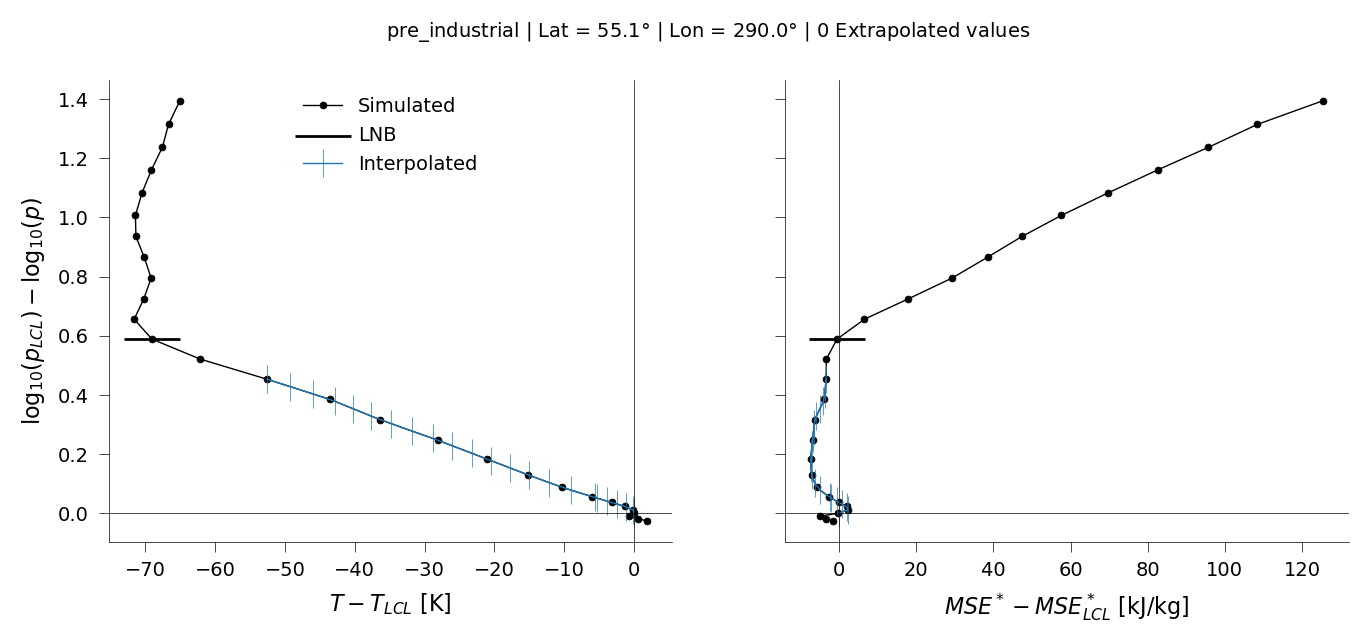

In [15]:
logp_grid = np.append(np.arange(0, 0.06, 0.01), np.arange(0.0525, 0.45+0.025, 0.025))        # finer close to LCL
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')  # Persian gulf
ds_use = ds.isel(co2=0).sel(lat=28, lon=50, method='nearest')   # Persian gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=-85, lon=100, method='nearest')       # Antarctic, hard test
ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')          # Small inversion near LCL
# ds_use = ds.isel(co2=0).sel(lat=-35, lon=125, method='nearest')       # Very big inversion at Ocean near Australia
# ds_use = ds.isel(co2=0).sel(lat=51, lon=90, method='nearest')         # Tibet, inversion type behaviour well above LCL
var, var2 = interp_var_to_logp(ds_use.T, ds_use.P, ds_use[f'T_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)

p_max = 30 * 100
# p_max = 200 * 100

fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 8)
ax[0].plot((ds_use.T - ds_use[f'T_at{lcl_use}']).where(ds_use.P >= p_max),
        (np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P)).where(ds_use.P >= p_max), marker='o', color='k',
        label='Simulated')
ax[0].scatter(ds_use.T.isel(lev=ds_use.lnb_ind) - ds_use[f'T_at{lcl_use}'],
           np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)),
           marker='_', s=400, lw=1, color='k', label='LNB')
ax[0].plot(var, var.logp_rel, marker='|', markersize=10, color='C0', label='Interpolated')
# if var.where(np.isnan(var), drop=True).size > 0:
#     ax.axhline(var.where(np.isnan(var), drop=True).logp_rel, color='C0', lw=ax_linewidth, label='Above LNB')

var, var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'],
                               ds_use.lnb_ind, logp_custom_grid=logp_grid)
ax[1].plot((ds_use.mse_sat - ds_use[f'mse_sat_at{lcl_use}']).where(ds_use.P >= p_max),
        (np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P)).where(ds_use.P >= p_max), marker='o', color='k',
        label='Simulated')
ax[1].scatter(ds_use.mse_sat.isel(lev=ds_use.lnb_ind) - ds_use[f'mse_sat_at{lcl_use}'],
           np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)),
           marker='_', s=400, lw=1, color='k', label='LNB')
ax[1].plot(var, var.logp_rel, marker='|', markersize=10, color='C0', label='Interpolated')
# ax[1].set_xlim(ax[1].get_xlim()[0], 20)

for i in range(2):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axvline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[0].set_xlabel('$T - T_{LCL}$ [K]')
ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax[0].set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
fig.suptitle(f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ | {var2:.0f} Extrapolated values")
plt.show()

### Coastline Issue
Below we see that on some coastlines, or bodies of water like great lakes region of North America, the empricial LCL is much closer to the surface than the physical LCL.

Then, we also see that in the layer just above the empirical LCL, there is a large reduction in $MSE^*$ indicative of CAPE, but really this arises because the lapse rate is close to dry adiabatic in that region.

Using physical LCL, the $MSE^*$ reduction is reduced, but still tends to be large in coastal regions, maybe indicating these are a mixture of regimes and hard to fit.

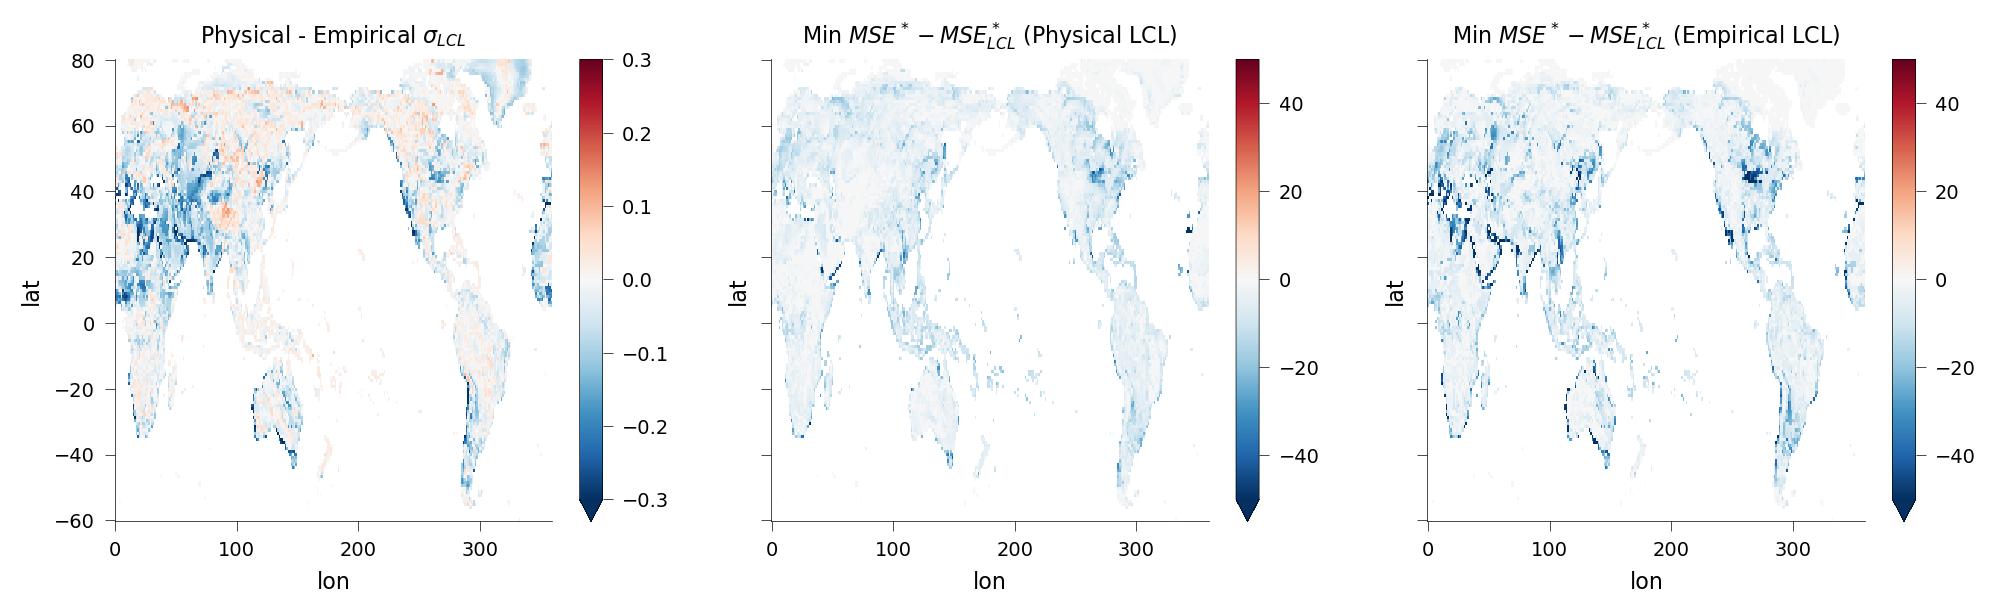

In [16]:
ds_use = ds.isel(co2=0).sel(lat=slice(-60, 80))
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
(ds_use.p_lcl/ds_use.PREFHT - ds_use.p_lcl_emp2/ds_use.PREFHT).where(lsm).plot(vmin=-0.3, ax=ax[0])
var = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use.mse_sat_at_lcl, ds_use.p_lcl, ds_use.lnb_ind, logp_custom_grid=logp_grid)
var[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[1])
var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use.mse_sat_at_lcl_emp2, ds_use.p_lcl_emp2, ds_use.lnb_ind, logp_custom_grid=logp_grid)
var2[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[2])
ax[0].set_title('Physical - Empirical $\sigma_{LCL}$')
ax[1].set_title('Min $MSE^* - MSE_{LCL}^*$ (Physical LCL)')
ax[2].set_title('Min $MSE^* - MSE_{LCL}^*$ (Empirical LCL)')
plt.show()

## PCA


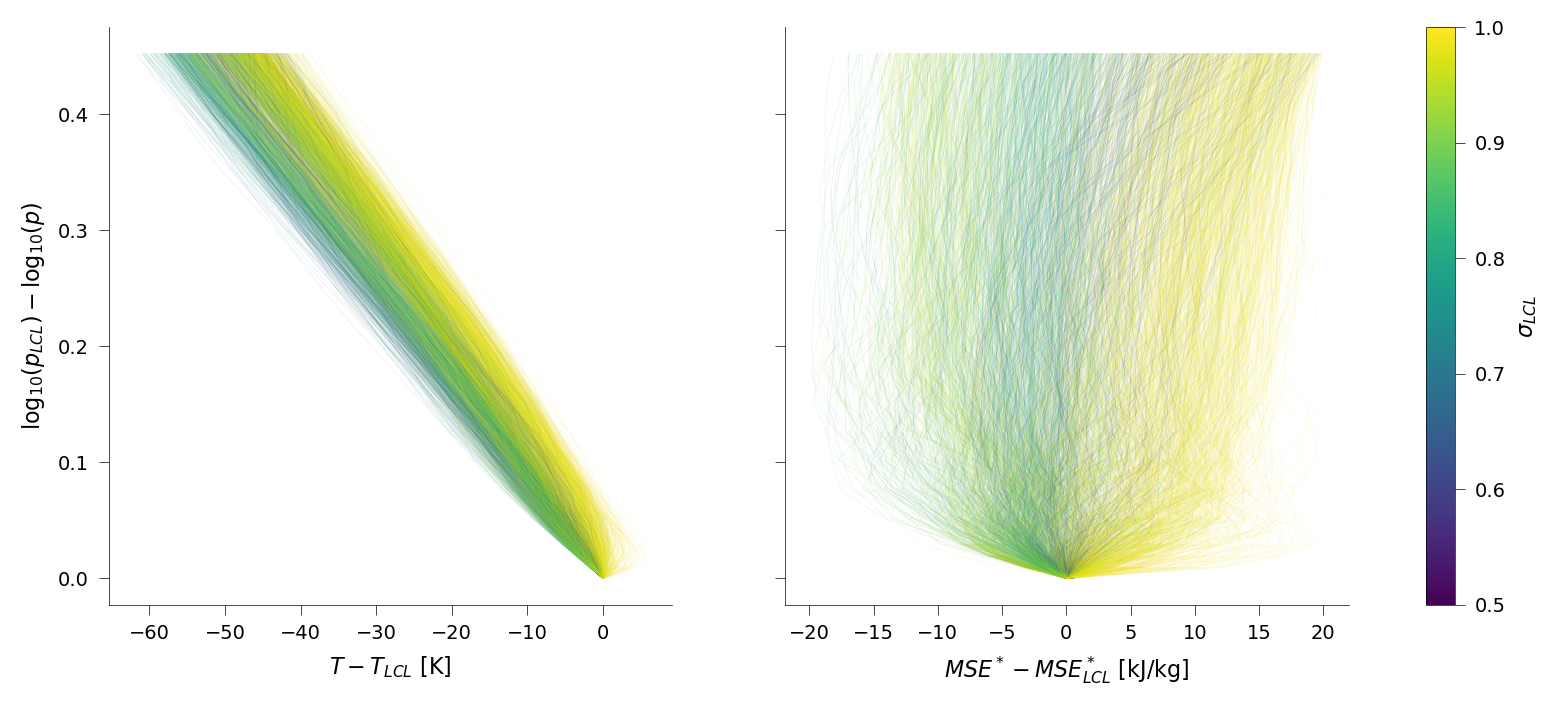

In [17]:
ds_use = ds.isel(co2=0).sel(lat=slice(-60, 80))
var = interp_var_to_logp(ds_use.T, ds_use.P, ds_use[f'T_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)
var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)

# Only show lines where max MSE deviation is mse_thresh, and no more than extrap_thresh levels above LNB
mse_thresh = 20
extrap_thresh = 2

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0.5, vmax=1)
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 10)

for i in range(0, ds_use.lat.size, 2):
    for j in range(0, ds_use.lon.size, 3):
        if lsm.isel(lat=i, lon=j):
            if var[1].isel(lat=i, lon=j) <= extrap_thresh:
                if np.abs(var2[0].isel(lat=i, lon=j)).max() < mse_thresh:
                    ax[0].plot(var[0].isel(lat=i, lon=j), var[0].logp_rel, alpha=0.1, lw=ax_linewidth,
                             c=cmap(norm((ds_use[f'p{lcl_use}']/ds_use.PREFHT).isel(lat=i, lon=j))))
                    ax[1].plot(var2[0].isel(lat=i, lon=j), var2[0].logp_rel, alpha=0.1, lw=ax_linewidth,
                             c=cmap(norm((ds_use[f'p{lcl_use}']/ds_use.PREFHT).isel(lat=i, lon=j))))
ax[0].set_xlabel('$T - T_{LCL}$ [K]')
ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax[0].set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for ScalarMappable
fig.colorbar(sm, ax=ax, label='$\sigma_{LCL}$')
plt.show()

In [18]:
# Old method forces mean to be subtracted when find PC. We want mean set to zero as this is expected from CQE
def pca_on_profiles_old(
    profiles: xr.DataArray,
    n_modes: int = 4,
    standardize: bool = True,
    valid: Optional[xr.DataArray] = None,
    lev_name: str = "logp_rel",
) -> Tuple[PCA, xr.DataArray, xr.DataArray, xr.DataArray, xr.DataArray]:
    """
    Run PCA on vertical profiles across a lat-lon grid (with optional extra dims).
    PCA is fit only on 'valid' locations (across *all* groups), but the same PCA
    is then applied to every profile in the dataset.

    Args:
        profiles (xr.DataArray): DataArray with dims (..., lev_name), typically
            (lat, lon, lev) or (co2, lat, lon, lev).
        n_modes (int): Number of PCA modes to keep.
        standardize (bool): If True, subtract mean profile and scale by stddev (levelwise).
        valid (Optional[xr.DataArray]): Boolean mask with same dims as profiles without lev.
            If None, all grid cells with finite profiles are considered valid.
        lev_name (str): Name of the vertical coordinate dimension.

    Returns:
        Tuple:
            - pca (PCA): Trained sklearn PCA object.
            - scores (xr.DataArray): PC scores with dims (*all non-lev dims, mode).
            - mean_profile (xr.DataArray): Mean profile used (dim lev).
            - std_profile (xr.DataArray): Std profile used (dim lev).
            - components (xr.DataArray): PCA components (EOFs), dims (mode, lev).
    """
    if lev_name not in profiles.dims:
        raise ValueError(f"profiles must have a '{lev_name}' dimension")

    # Identify spatial dims (must be 2D lat-lon like)
    spatial_dims = [d for d in profiles.dims if d != lev_name]
    if len(spatial_dims) < 2:
        raise ValueError("profiles must have at least two spatial dims (lat, lon style) + lev_name")

    # Default valid mask = finite profiles everywhere along lev
    if valid is None:
        valid = np.isfinite(profiles).all(lev_name)

    # Flatten everything except lev_name
    X = profiles.stack(points=spatial_dims)
    valid_flat = valid.stack(points=spatial_dims)

    # --- FIT PCA ONLY ON VALID PROFILES ---
    X_valid = X[:, valid_flat]
    X_valid = X_valid.transpose("points", lev_name).values  # (n_valid, n_lev)
    if X_valid.shape[0] < n_modes + 1:
        raise ValueError("Too few valid profiles for PCA; reduce n_modes or check coverage.")

    # Mean / std from valid only
    mean_profile = X_valid.mean(axis=0) * 0
    Xc_valid = X_valid - mean_profile
    if standardize:
        std_profile = Xc_valid.std(axis=0, ddof=1)
        std_profile[std_profile == 0] = 1.0
        Xc_valid /= std_profile
    else:
        std_profile = np.ones_like(mean_profile)

    # Fit PCA on valid subset
    pca = PCA(n_components=n_modes)
    pca.fit(Xc_valid)

    # --- PROJECT ALL PROFILES USING SAME PCA ---
    scores_all = np.full((X.shape[1], n_modes), np.nan)  # (npoints, n_modes)
    mask_finite = np.isfinite(X).all(lev_name)
    if mask_finite.any():
        X_all = ((X[:, mask_finite].transpose("points", lev_name).values - mean_profile) / std_profile)
        scores_all[mask_finite.values, :] = pca.transform(X_all)

    # Restore to original dims (replace lev with mode)
    out_shape = tuple([profiles.sizes[d] for d in spatial_dims] + [n_modes])
    scores = xr.DataArray(
        scores_all.reshape(out_shape),
        dims=spatial_dims + ["mode"],
        coords={**{d: profiles[d] for d in spatial_dims}, "mode": np.arange(n_modes)},
    )

    # Wrap mean/std/components
    mean_profile = xr.DataArray(mean_profile, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    std_profile = xr.DataArray(std_profile, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    components = xr.DataArray(pca.components_, dims=("mode", lev_name),
                              coords={"mode": np.arange(n_modes), lev_name: profiles[lev_name]})

    return pca, scores, mean_profile, std_profile, components

In [19]:
def pca_on_profiles(
    profiles: xr.DataArray,
    n_modes: int = 4,
    standardize: bool = True,
    valid: Optional[xr.DataArray] = None,
    lev_name: str = "logp_rel",
    reference_mean: Optional[xr.DataArray] = None,
) -> Tuple[xr.DataArray, xr.DataArray, xr.DataArray, xr.DataArray, np.ndarray, np.ndarray]:
    """
    Perform PCA (via SVD) on vertical profiles enforcing a fixed reference mean
    (e.g. zero). The PCA is fit only on profiles where `valid` is True, and the
    same components are applied to all profiles in `profiles`.

    Args:
        profiles (xr.DataArray): DataArray with dims (..., lev_name) (e.g. (co2, lat, lon, lev)).
        n_modes (int): Number of PCA modes to keep.
        standardize (bool): If True, divide each level by its std (computed from valid points)
            *before* SVD so that levels with different variances are equalized.
            If False, SVD is performed on raw deviations from `reference_mean`.
        valid (Optional[xr.DataArray]): Boolean mask with the same non-lev dims as `profiles`.
            True indicates the grid cell is used to compute the PCA basis. If None, all
            grid cells with finite values across lev are considered valid.
        lev_name (str): Name of the vertical dimension in `profiles`.
        reference_mean (Optional[xr.DataArray]): 1-D DataArray (dim lev_name) to subtract before SVD.
            If None, a zero reference mean is used (i.e. PCA on deviations from zero).

    Returns:
        components (xr.DataArray): EOFs (modes) with dims ("mode", lev_name).
        scores (xr.DataArray): PC coefficients with dims (all non-lev dims..., "mode").
        mean_profile (xr.DataArray): The reference_mean actually used (dim lev_name).
        std_profile (xr.DataArray): Std used for scaling (dim lev_name). Ones if standardize=False.

    Notes:
        - This function uses np.linalg.svd directly so there is NO automatic re-centering:
          the `reference_mean` you supply (or zero) is the baseline from which deviations
          are computed.
        - If standardize=True, std_profile is computed from the valid set and used both
          for the SVD input and for projecting all profiles.
    """
    # --- checks ---
    if lev_name not in profiles.dims:
        raise ValueError(f"profiles must have a '{lev_name}' dimension")

    # dims except vertical
    nonlev_dims = [d for d in profiles.dims if d != lev_name]
    if len(nonlev_dims) < 2:
        # still allow any number of non-lev dims (e.g. co2, lat, lon) as long as lev exists
        pass

    # default valid: finite across lev
    if valid is None:
        valid = np.isfinite(profiles).all(dim=lev_name)

    # stack all non-lev dims into a single "points" axis
    stacked = profiles.stack(points=nonlev_dims)  # dims (..., lev_name) -> (points, lev_name) after transpose
    stacked = stacked.transpose("points", lev_name)  # ensure order is (points, lev)
    n_points = stacked.sizes["points"]
    n_lev = stacked.sizes[lev_name]

    # flatten valid mask to points
    valid_flat = valid.stack(points=nonlev_dims)
    valid_mask = valid_flat.values.astype(bool)
    n_valid = int(valid_mask.sum())
    if n_valid < (n_modes + 1):
        raise ValueError("Too few valid profiles for PCA; reduce n_modes or check coverage.")

    # prepare reference mean (1d array length n_lev)
    if reference_mean is None:
        reference_mean_vals = np.zeros(n_lev)
        reference_mean_da = xr.DataArray(reference_mean_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    else:
        # allow reference_mean to be xr.DataArray aligned on lev_name
        reference_mean_da = reference_mean.copy()
        if lev_name not in reference_mean_da.dims:
            raise ValueError("reference_mean must have dimension named lev_name")
        # align and extract numeric array in lev order of profiles
        reference_mean_da = reference_mean_da.reindex({lev_name: profiles[lev_name]})
        reference_mean_vals = reference_mean_da.values

    # build matrix of valid rows (n_valid, n_lev)
    X_all = stacked.values  # shape (n_points, n_lev)
    X_valid = X_all[valid_mask, :]  # (n_valid, n_lev)

    # subtract reference mean
    Xc_valid = X_valid - reference_mean_vals[None, :]

    # compute std_profile from valid subset if requested
    if standardize:
        std_profile_vals = Xc_valid.std(axis=0, ddof=1)
        # avoid zeros
        std_profile_vals = np.where(std_profile_vals == 0, 1.0, std_profile_vals)
        Xc_valid = Xc_valid / std_profile_vals[None, :]
    else:
        std_profile_vals = np.ones(n_lev)

    # --- SVD on the prepared valid data (no further centering) ---
    # Xc_valid shape: (n_valid, n_lev). compute thin SVD
    U, S, Vt = np.linalg.svd(Xc_valid, full_matrices=False)
    # components (EOFs) are rows of Vt; keep first n_modes
    components_vals = Vt[:n_modes, :]  # (n_modes, n_lev)

    # --- project ALL profiles using same transform ---
    # subtract reference mean and divide by std_profile (if standardize)
    Xc_all = X_all - reference_mean_vals[None, :]
    if standardize:
        Xc_all = Xc_all / std_profile_vals[None, :]

    # scores_all: (n_points, n_modes)
    scores_all = Xc_all @ components_vals.T

    # reshape back to original non-lev dims + mode
    out_shape = [profiles.sizes[d] for d in nonlev_dims] + [n_modes]
    scores_da = xr.DataArray(
        scores_all.reshape(*out_shape),
        dims=nonlev_dims + ["mode"],
        coords={**{d: profiles[d] for d in nonlev_dims}, "mode": np.arange(n_modes)}
    )

    components_da = xr.DataArray(
        components_vals,
        dims=("mode", lev_name),
        coords={"mode": np.arange(n_modes), lev_name: profiles[lev_name]}
    )

    mean_profile_da = xr.DataArray(reference_mean_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})
    std_profile_da = xr.DataArray(std_profile_vals, dims=(lev_name,), coords={lev_name: profiles[lev_name]})

    # Variance explained by each mode
    var_explained = (S**2) / (Xc_valid.shape[0] - 1)

    # Fractional variance explained
    frac_var_explained = var_explained / var_explained.sum()

    return components_da, scores_da, mean_profile_da, std_profile_da, var_explained[:n_modes], frac_var_explained[:n_modes]



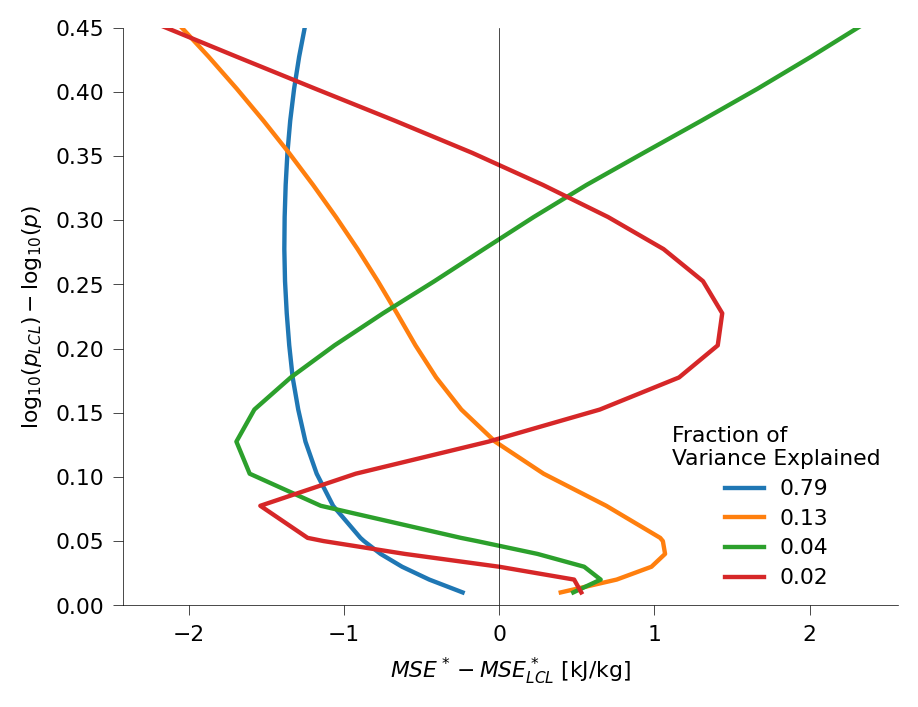

In [20]:
ds_use = ds.isel(co2=[0, 1])
var = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)
valid = (lsm > 0) & (var[1] <= 2) & (np.abs(var[0]).max(dim='logp_rel') <= 20) & (ds_use.lat > -60) & (ds_use.lat < 75)

n_modes = 4
pca_output = list(pca_on_profiles(var[0].isel(logp_rel=slice(1, 9999)), valid=valid, standardize=True, n_modes=n_modes))

fig, ax = plt.subplots(1, 1, sharey=True)
fig_resize(fig, 5)
for i in range(n_modes):
    ax.plot(pca_output[0].isel(mode=i) * pca_output[3], var[0].isel(logp_rel=slice(1, 9999)).logp_rel,
            label=f'{pca_output[-1][i]:.2f}', color=f'C{i}')
ax.set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax.set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.set_ylim(0, 0.45)
update_linewidth(fig)
ax.legend(title='Fraction of\nVariance Explained')
ax.axvline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, base_fontsize=5)
plt.show()

In [21]:
def make_coefs_sparse(profiles, pca_comp, pca_coef, pca_std, error_thresh = 1):
    error_initial = np.sqrt(((profiles - (pca_comp * pca_coef).sum(dim='mode') * pca_std)**2).sum(dim='logp_rel'))
    n_mode = pca_comp.mode.size
    pca_coef_out = pca_coef * 1
    for i in range(n_mode):
        pca_coef_use = pca_coef.where(pca_coef.mode!=i, 0)
        error_use = np.sqrt(((profiles - (pca_comp * pca_coef_use).sum(dim='mode') * pca_std)**2).sum(dim='logp_rel'))
        make_sparse = error_use - error_initial < error_thresh
        make_sparse = make_sparse  & (pca_coef.mode==i)         # want to just make the current coefficient 0
        pca_coef_out = pca_coef_out.where(~make_sparse, 0)
    return pca_coef_out
# where coefficients are not important, set the coefficient to 0 i.e. ensure sparsity
if int((pca_output[1]==0).sum()) == 0:
    pca_output[1] = make_coefs_sparse(var[0], pca_output[0], pca_output[1], pca_output[3], error_thresh = 1)

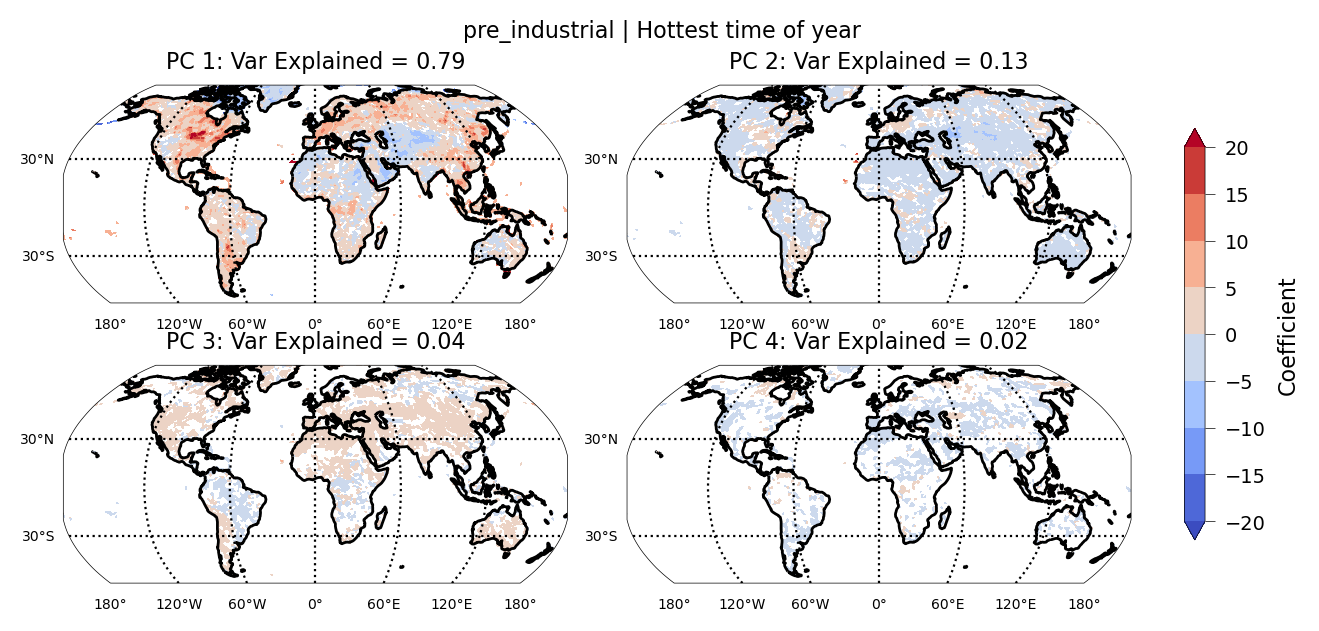

In [22]:
co2_ind = 0
levels_use = np.arange(-20, 25, 5)
fig = plt.figure(constrained_layout=True, figsize=(6.5, 3))
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
for i, ax_use in enumerate(ax.flatten()):
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = plot_contour_projection(ax_use, pca_output[1].isel(co2=co2_ind, mode=i),
                        cmap='coolwarm', levels=levels_use, mask=lsm & (pca_output[1].isel(co2=co2_ind, mode=i)!=0))
    ax_use.set_title(f'PC {i+1}: Var Explained = {pca_output[-1][i]:.2f}')
fig.colorbar(shrink=0.8, ax=ax.ravel(), label='Coefficient', mappable=im)
fig.suptitle(f'{exp_name[co2_ind]} | Hottest time of year', fontsize=8)
# isca_tools.savefig(fig)
plt.show()

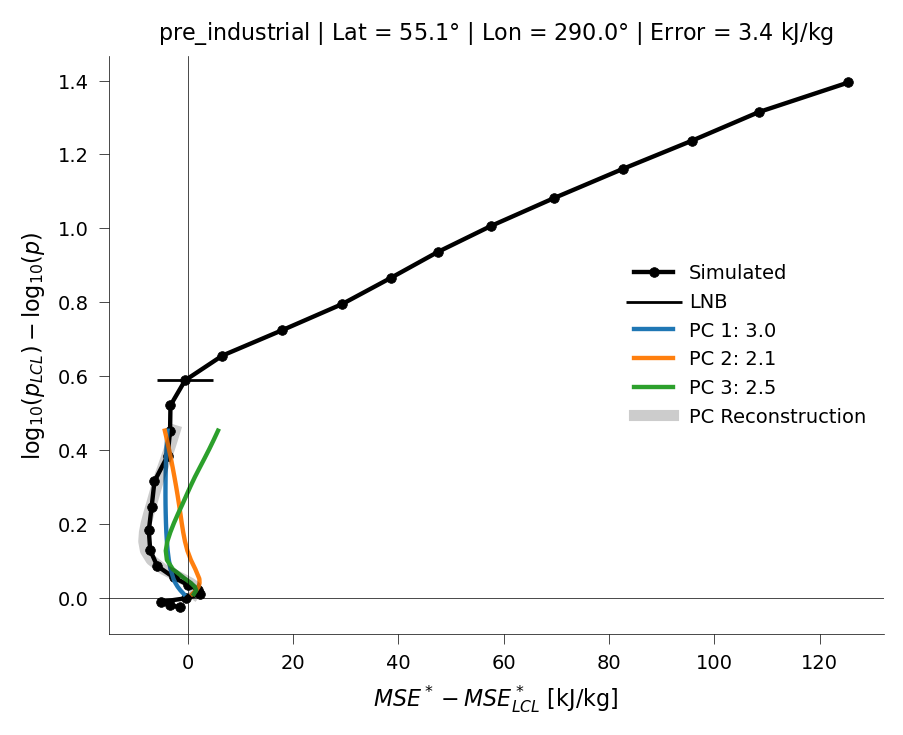

In [23]:
# coord_use = {'co2': 0, 'lat': 25, 'lon': 50}            # Persian gulf
coord_use = {'co2': 0, 'lat': 28, 'lon': 50}          # Persian gulf coast
# coord_use = {'co2': 0, 'lat': -85, 'lon': 100}          # Antarctic, hard test
# coord_use = {'co2': 0, 'lat': 51, 'lon': 90}            # Tibet
coord_use = {'co2': 0, 'lat': 55, 'lon': 290}           # Canada
ds_use = ds.isel(co2=coord_use['co2']).sel(lat=coord_use['lat'], lon=coord_use['lon'], method='nearest')  # Canada
pc_coefs_use = pca_output[1].isel(co2=coord_use['co2']).sel(lat=coord_use['lat'], lon=coord_use['lon'], method='nearest')

p_max = 30 * 100
# p_max = 200 * 100

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 5)

# var, var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)
ax.plot((ds_use.mse_sat - ds_use[f'mse_sat_at{lcl_use}']).where(ds_use.P >= p_max),
        (np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P)).where(ds_use.P >= p_max), marker='o', color='k', markersize=3.5,
        label='Simulated')
ax.scatter(ds_use.mse_sat.isel(lev=ds_use.lnb_ind) - ds_use[f'mse_sat_at{lcl_use}'],
           np.log10(ds_use[f'p{lcl_use}']) - np.log10(ds_use.P.isel(lev=ds_use.lnb_ind)),
           marker='_', s=400, lw=1, color='k', label='LNB')
for i in range(n_modes):
    if pc_coefs_use.isel(mode=i) == 0:
        continue
    ax.plot(pca_output[0].isel(mode=i) * pc_coefs_use.isel(mode=i) * pca_output[3], pca_output[0].logp_rel, color=f'C{i}',
            label=f'PC {i+1}: {pc_coefs_use[i]:.1f}')
update_linewidth(fig)
ax.plot((pca_output[0] * pc_coefs_use * pca_output[3]).sum(dim='mode'), pca_output[0].logp_rel, color='k', alpha=0.2, lw=4,
        label='PC Reconstruction')

var = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use[f'mse_sat_at{lcl_use}'], ds_use[f'p{lcl_use}'], ds_use.lnb_ind, logp_custom_grid=logp_grid)[0]
var = var.isel(logp_rel=slice(1, 9999))
error = np.sqrt(((var - (pca_output[0] * pc_coefs_use * pca_output[3]).sum(dim='mode'))**2).sum(dim='logp_rel'))

# ax[1].plot(var, var.logp_rel, marker='|', markersize=10, color='C0', label='Interpolated')
# ax[1].set_xlim(ax[1].get_xlim()[0], 20)

# for i in range(2):
# update_linewidth(fig)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
# ax[0].legend()
# ax[0].set_xlabel('$T - T_{LCL}$ [K]')
# ax[1].set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
# ax[0].set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.legend()
ax.set_xlabel('$MSE^* - MSE^*_{LCL}$ [kJ/kg]')
ax.set_ylabel('$\log_{10}(p_{LCL}) - \log_{10}(p)$')
ax.set_title(f"{exp_name[int(ds_use.co2) - 1]} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ | Error = {error:.1f} kJ/kg")
plt.show()

## Reconstructing $T_{LCL}$
From the PC decomposition, we can reconstruct for each location $\epsilon = h_{LCL}^* - h_{FT}^* \approx -\sum_i x_i \chi_i(p_{FT})$

where $x$ is the coefficient at that location, and $\chi$ is the PC (same for all locations), and $i$ refers to the PC number.

After finding $\epsilon$, we can use our $z$ approximation to find an estimate for $T_{LCL}$ and the contribution from each PC.

In [24]:
p_ft = 500 * 100
ds['T_ft'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), float(ds.P0.isel(co2=0)),
                                       np.atleast_1d(p_ft), lev_dim='lev').load()
ds['Z_ft'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), float(ds.P0.isel(co2=0)),
                                       np.atleast_1d(p_ft), lev_dim='lev').load()
ds['mse_sat_ft'] = moist_static_energy(ds.T_ft, sphum_sat(ds.T_ft, p_ft), ds.Z_ft)

# Find value of each PC at p_ft i.e. where LCL closer to p_ft, expect indices to be closer to 0
p_pca_env = ds[f'p{lcl_use}'] * 10**(-pca_output[0].logp_rel)       # pressures used for PC finding at each lat, lon
# Remember to multiply by std_dev at each level pca_output[3] to give each PC at FT level for each location
pca_ft_val = get_var_at_plev(pca_output[0] * pca_output[3], p_pca_env,
                             p_ft, lev_dim='logp_rel', method='linear')

epsilon_from_pca = (-pca_ft_val * pca_output[1]).sum(dim='mode')        # multiply PC at p_ft by the PC coefficient
temp_at_lcl_theory = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                           pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=epsilon_from_pca)

Reversed order of logp_rel for interpolation so p_env is ascending


### $\epsilon$ sanity check
Below we confirm the $\epsilon$ computed from PCs match the simulated value. We mask locations where $p_{LCL} < p_{FT}$ e.g. Tibet.

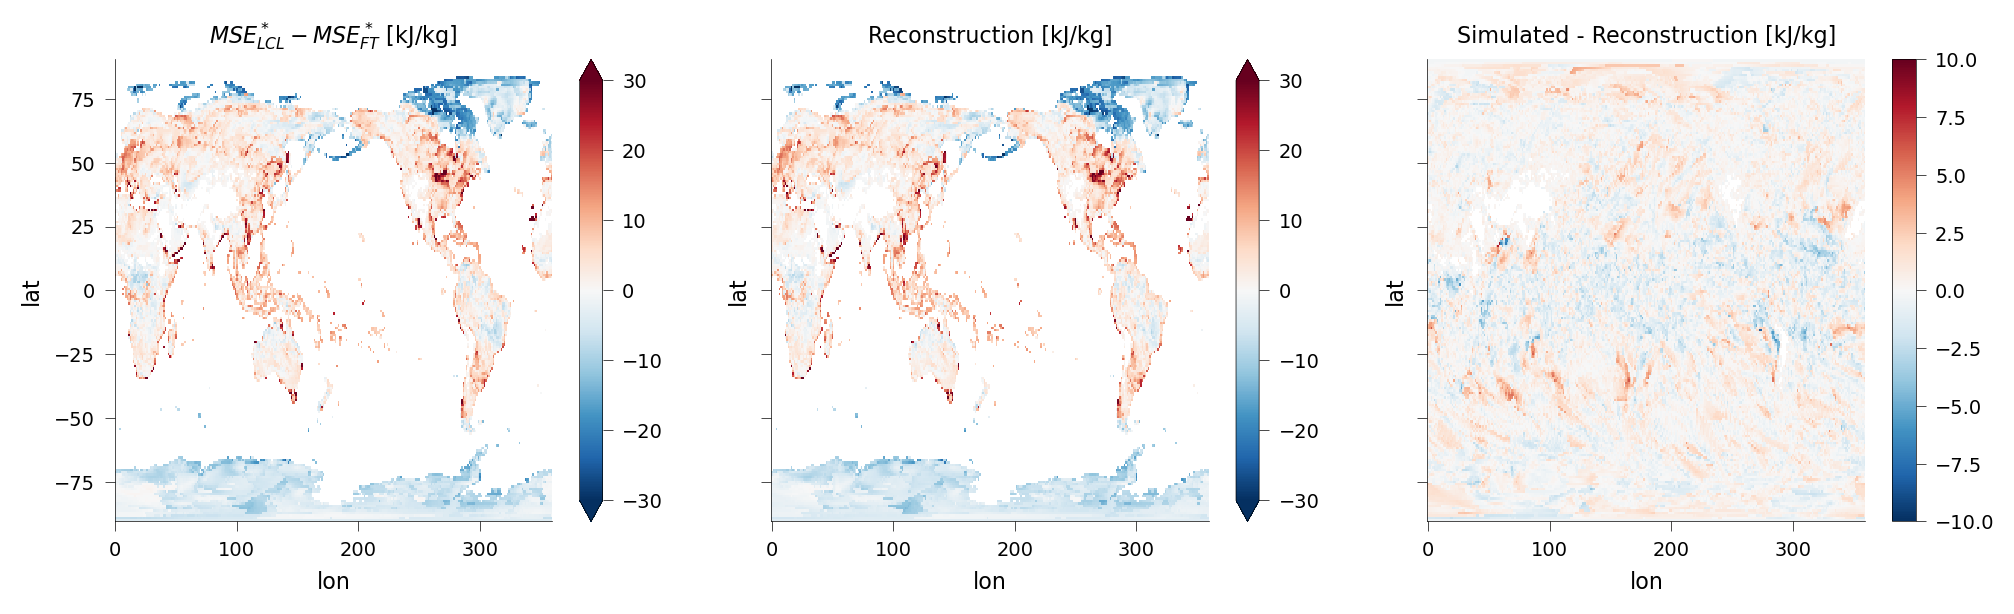

In [83]:
co2_ind = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
epsilon = ds['mse_sat_at_lcl'] - ds['mse_sat_ft']
epsilon.where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-30, ax=ax[0])
epsilon_from_pca.where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-30, ax=ax[1])
(epsilon - epsilon_from_pca).where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).plot(vmin=-10, ax=ax[2])
ax[0].set_title('$MSE_{LCL}^* - MSE_{FT}^*$ [kJ/kg]')
ax[1].set_title('Reconstruction [kJ/kg]')
ax[2].set_title('Simulated - Reconstruction [kJ/kg]')
plt.show()

### $T_{LCL}$ sanity check
Below, we compare the reconstructed LCL temperature from the PCs to the simulated value.

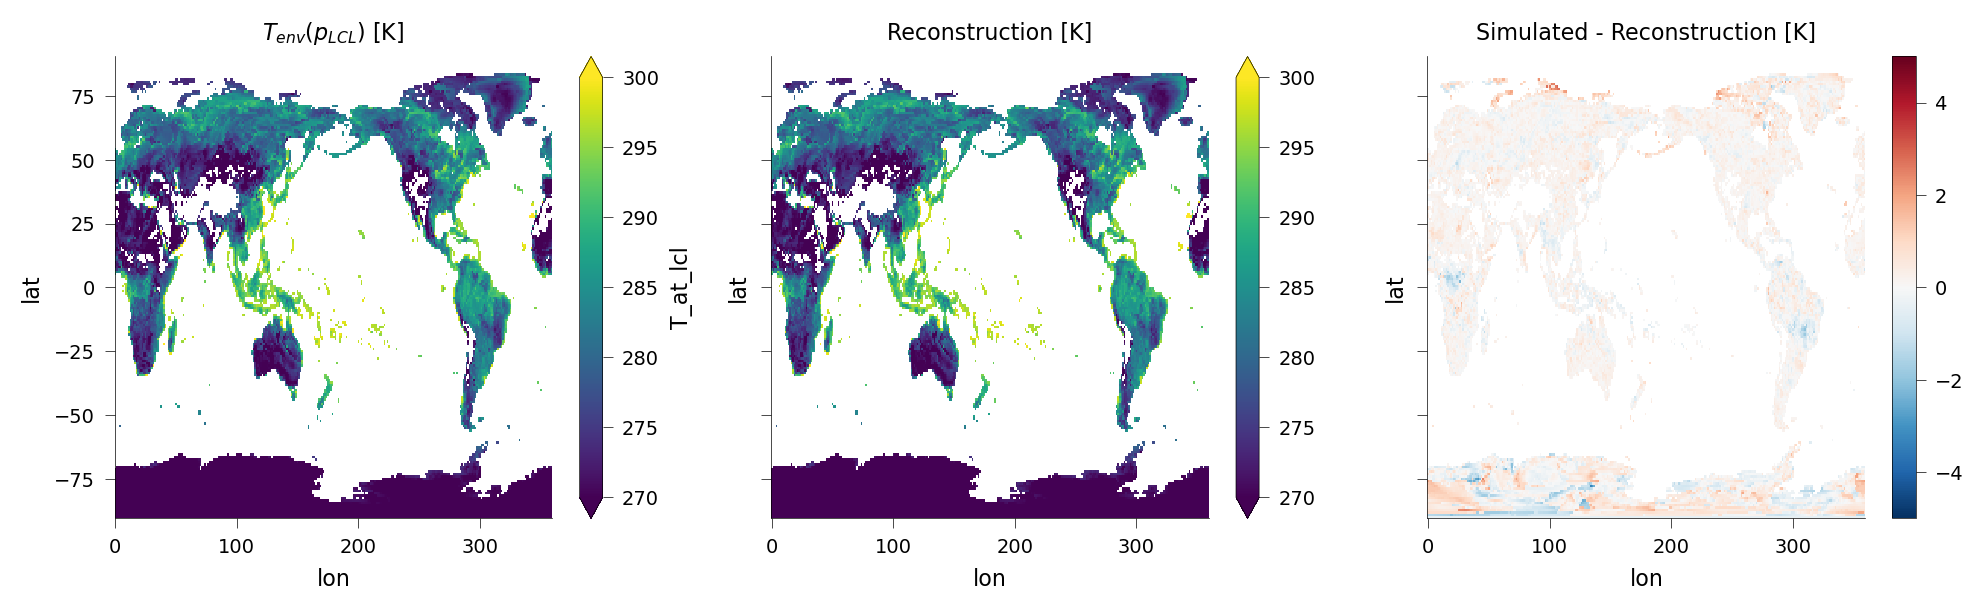

In [30]:
co2_ind = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
ds[f'T_at{lcl_use}'].where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300, ax=ax[0])
temp_at_lcl_theory.where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300, ax=ax[1])
(ds[f'T_at{lcl_use}'] - temp_at_lcl_theory).where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=-5, ax=ax[2])
ax[0].set_title('$T_{env}(p_{LCL})$ [K]')
ax[1].set_title('Reconstruction [K]')
ax[2].set_title('Simulated - Reconstruction [K]')
plt.show()

In [ ]:
temp_at_lcl_no_epsilon = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                           pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=0)

In [ ]:
temp_at_lcl_theory_cont = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                                pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=-pca_ft_val * pca_output[1]) - \
    temp_at_lcl_no_epsilon

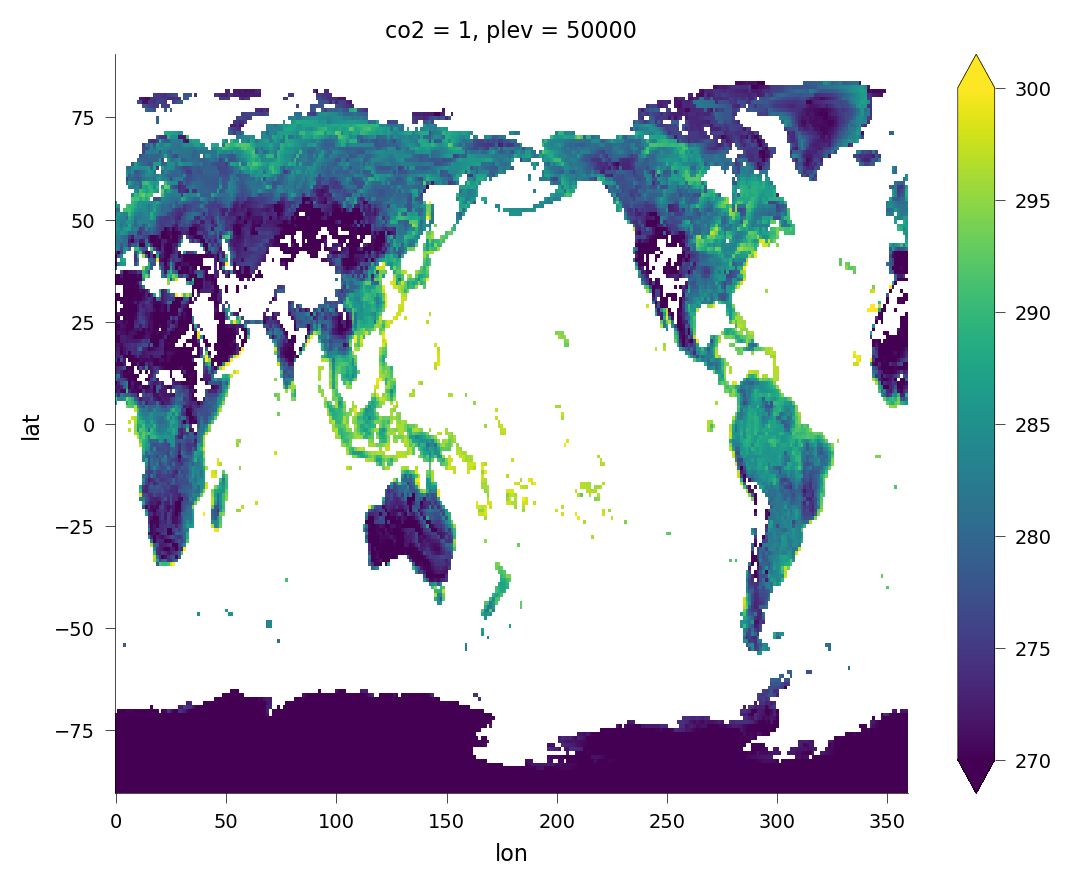

In [46]:
# If linear approx ok, should look like temp_at_lcl above
(temp_at_lcl_no_epsilon + temp_at_lcl_theory_cont.sum(dim='mode')
 ).isel(co2=0).where(ds[f'p{lcl_use}']>p_ft).isel(co2=co2_ind).where(lsm).plot(vmin=270, vmax=300)

In [27]:
mask_ref = lsm & (lsm.lat > -60) & (lsm.lat < 80) & (ds[f'p{lcl_use}'] > 1.2 * p_ft)

In [28]:
mask_ref = lsm & (lsm.lat > -60) & (lsm.lat < 80) & (ds[f'p{lcl_use}'] > 1.2 * p_ft)
temp_ft_ref = ds.T_ft.where(mask_ref).mean(dim=['lat', 'lon', 'plev'])
p_lcl_ref = ds[f'p{lcl_use}'].where(mask_ref).mean(dim=['lat', 'lon', 'co2'])
epsilon_ref = 0
temp_at_lcl_ref = get_temp_adiabat_surf(1, temp_ft_ref, z_ft=None, pressure_ft=p_ft,
                                           pressure_surf=p_lcl_ref, rh_form=True, epsilon=epsilon_ref)

In [33]:
temp_at_lcl_no_epsilon = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                           pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=0)

In [34]:
temp_at_lcl_theory_cont = get_temp_adiabat_surf(1, ds.T_ft.isel(plev=0), z_ft=None, pressure_ft=p_ft,
                                                pressure_surf=ds[f'p{lcl_use}'], rh_form=True, epsilon=-pca_ft_val * pca_output[1]) - \
    temp_at_lcl_no_epsilon

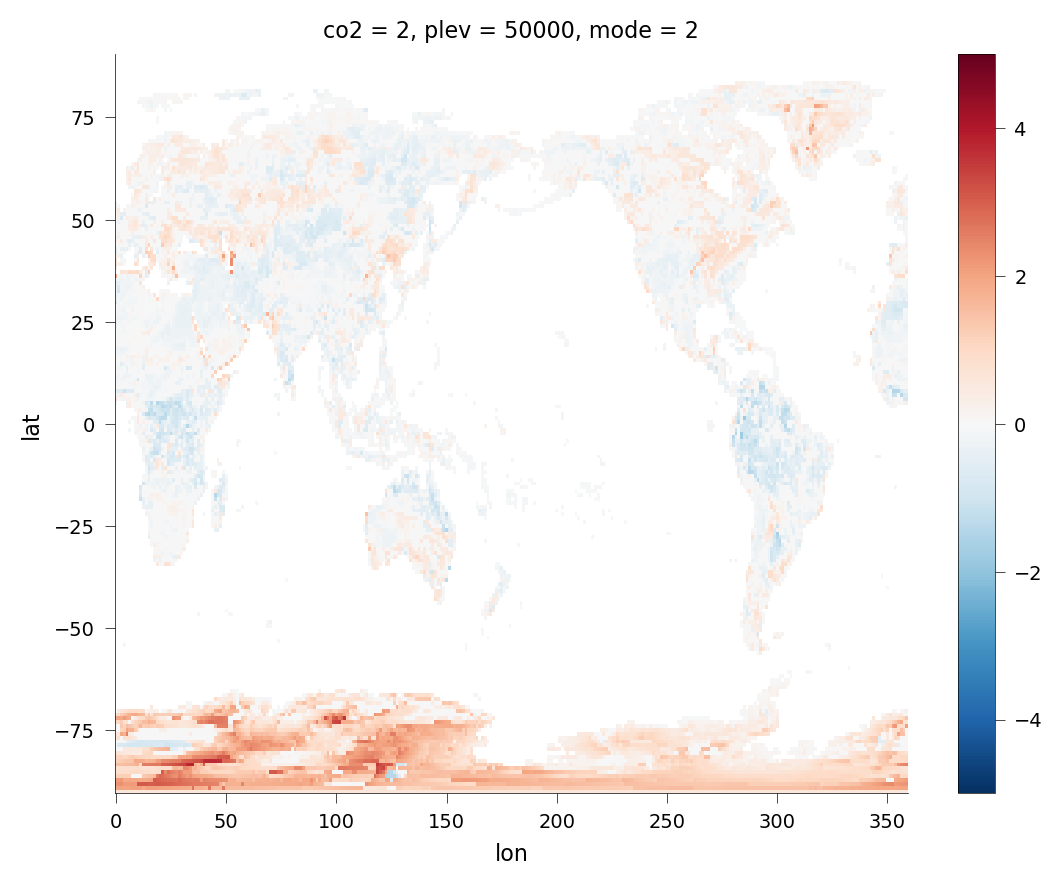

In [91]:
temp_at_lcl_theory_cont.isel(mode=2, co2=1).where(lsm).plot(vmax=5)

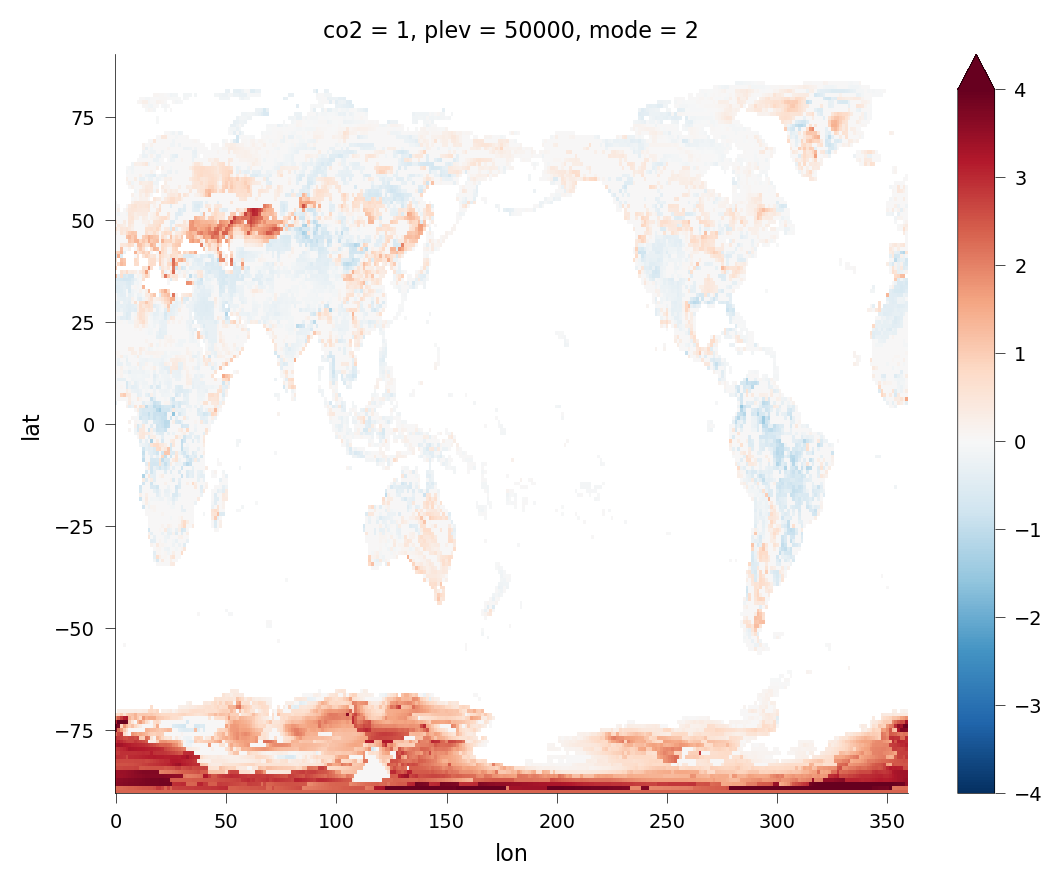

In [79]:
temp_at_lcl_theory_cont.isel(mode=2, co2=0).where(lsm).plot(vmax=4)

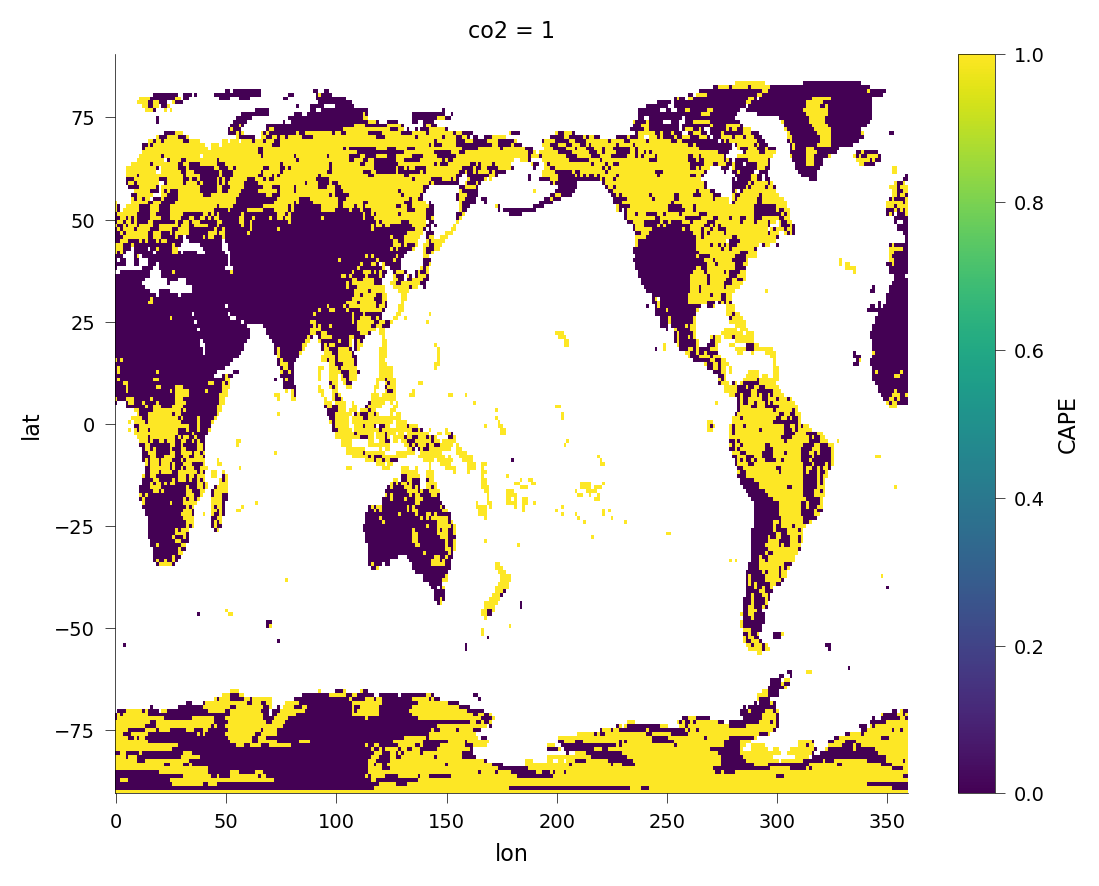

In [58]:
(ds.CAPE.isel(co2=0)>10).where(lsm).plot()

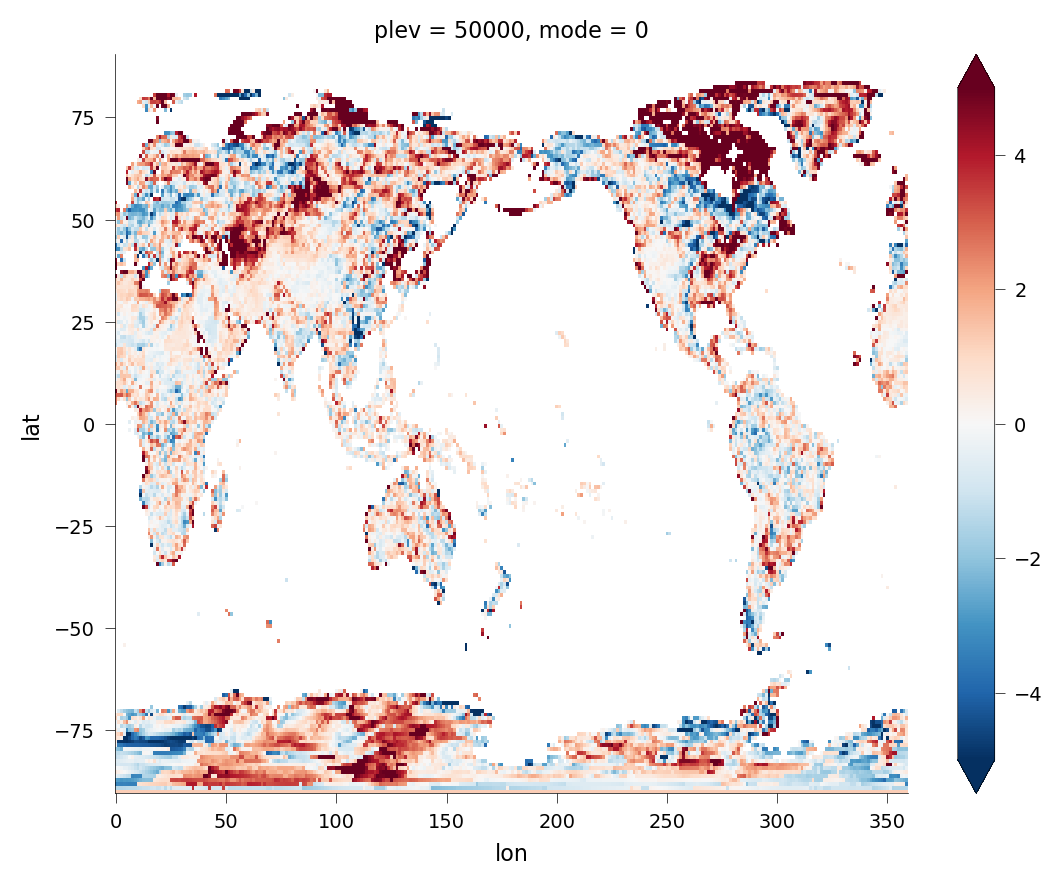

In [82]:
(temp_at_lcl_theory_cont.isel(mode=0, co2=1) - temp_at_lcl_theory_cont.isel(mode=0, co2=0)).where(lsm).plot(vmax=5)